In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import pickle
from random import sample

In [2]:
train_df = pd.read_csv('data/mitbih_train.csv', header=None)
test_df = pd.read_csv('data/mitbih_test.csv', header=None)

In [3]:
def get_padding_start_index(row):
    start_index = 187
    for i in row[::-1]:
        if i != 0.0:
            return start_index

        start_index -= 1


def plot_scan(df, i):
    plt.figure()
    plt.plot(df.iloc[i, :187])


def stretch(signal):
    stretched = [0.0 for i in range(187)]
    for i in range(187):
        scaled_i = i * 2
        if scaled_i < len(stretched):
            stretched[scaled_i] = signal.iloc[i]
        else:
            break

    for i in range(187):
        if not stretched[i]:
            count = 2
            for j in range(i + 1, 187):
                if stretched[j]:
                    stretched[i] = (stretched[i - 1] + stretched[j]) / count
                    break
                count += 1

    return stretched


def squeeze(signal):
    squeezed = []
    i = 0
    while i < len(signal):
        squeezed.append(signal[i])
        i += 2

    for i in range(187 - len(squeezed)):
        squeezed.append(0.0)

    return squeezed

In [7]:
flipped_list = []
noise_list = []
shuffled_list = []
stretched_list = []
squeezed_list = []

segment_length = 8  # Length of segments to get shuffled

# Flip, add noise, shuffle, squeeze and stretch
print("Start Flip, add noise, shuffle, squeeze and stretch for training data")
for row_i in range(len(train_df)):
    padding_i = get_padding_start_index(train_df.iloc[row_i, :187])

    flipped_list.append(train_df.iloc[row_i, 0:padding_i].iloc[::-1].tolist() +
                        train_df.iloc[row_i, padding_i:].tolist())

    noise_list.append(train_df.iloc[row_i, 0:padding_i].transform(lambda x: x + np.random.normal(0, 0.1)).tolist() +
                      train_df.iloc[row_i, padding_i:].tolist())  # Change 0.1 for more or less noise

    n_segments = int(padding_i / segment_length)
    shuffled_index = sample(range(0, n_segments), n_segments)
    shuffled_row_list = []
    for shuffled_i in shuffled_index:
        start_i = shuffled_i * segment_length
        if shuffled_i == n_segments - 1:
            end_i = (shuffled_i * segment_length) + segment_length + (padding_i - (n_segments * segment_length))
        else:
            end_i = (shuffled_i * segment_length) + segment_length
        shuffled_row_list += train_df.iloc[row_i, start_i:end_i].tolist()

    shuffled_list.append(shuffled_row_list + train_df.iloc[row_i, padding_i:].tolist())

    stretched_list.append(stretch(train_df.iloc[row_i, :187]) + [train_df.iloc[row_i, 187]])
    squeezed_list.append(squeeze(train_df.iloc[row_i, :187]) + [train_df.iloc[row_i, 187]])

train_df_flipped = pd.DataFrame(flipped_list)
train_df_noise = pd.DataFrame(noise_list)
train_df_shuffled = pd.DataFrame(shuffled_list)
train_df_stretched = pd.DataFrame(stretched_list)
train_df_squeezed = pd.DataFrame(squeezed_list)

Start Flip, add noise, shuffle, squeeze and stretch for training data


In [8]:
flipped_list = []
noise_list = []
shuffled_list = []
stretched_list = []
squeezed_list = []

segment_length = 8
print("Start Flip, add noise, shuffle, squeeze and stretch for testing data")
for row_i in range(len(test_df)):
    padding_i = get_padding_start_index(test_df.iloc[row_i, :187])

    flipped_list.append(test_df.iloc[row_i, 0:padding_i].iloc[::-1].tolist() +
                        test_df.iloc[row_i, padding_i:].tolist())

    noise_list.append(test_df.iloc[row_i, 0:padding_i].transform(lambda x: x + np.random.normal(0, 0.1)).tolist() +
                      test_df.iloc[row_i, padding_i:].tolist())  # Change 0.1 for more or less noise

    n_segments = int(padding_i / segment_length)
    shuffled_index = sample(range(0, n_segments), n_segments)
    shuffled_row_list = []
    for shuffled_i in shuffled_index:
        start_i = shuffled_i * segment_length
        if shuffled_i == n_segments - 1:
            end_i = (shuffled_i * segment_length) + segment_length + (padding_i - (n_segments * segment_length))
        else:
            end_i = (shuffled_i * segment_length) + segment_length
        shuffled_row_list += test_df.iloc[row_i, start_i:end_i].tolist()

    shuffled_list.append(shuffled_row_list + test_df.iloc[row_i, padding_i:187].tolist())

    stretched_list.append(stretch(test_df.iloc[row_i, :187]) + [test_df.iloc[row_i, 187]])
    squeezed_list.append(squeeze(test_df.iloc[row_i, :187]) + [test_df.iloc[row_i, 187]])

test_df_flipped = pd.DataFrame(flipped_list)
test_df_noise = pd.DataFrame(noise_list)
test_df_shuffled = pd.DataFrame(shuffled_list)
test_df_stretched = pd.DataFrame(stretched_list)
test_df_squeezed = pd.DataFrame(squeezed_list)

Start Flip, add noise, shuffle, squeeze and stretch for testing data


In [9]:
# Negated
train_df_negated = train_df.iloc[:, :187].transform(lambda x: x * -1)
train_df_negated.loc[:, 187] = train_df.iloc[:, 187].to_numpy()

test_df_negated = test_df.iloc[:, :187].transform(lambda x: x * -1)
test_df_negated.loc[:, 187] = test_df.iloc[:, 187].to_numpy()

In [10]:
# Scaled
scale_factor = 0.1  # Change for more or less scaling
train_df_scaled = train_df.iloc[:, :187].transform(lambda x: x * scale_factor)
train_df_scaled.loc[:, 187] = train_df.iloc[:, 187].to_numpy()

test_df_scaled = test_df.iloc[:, :187].transform(lambda x: x * scale_factor)
test_df_scaled.loc[:, 187] = test_df.iloc[:, 187].to_numpy()

In [11]:
train_df.loc[:, 187] = 0
test_df.loc[:, 187] = 0

train_df_flipped.loc[:, 187] = 1
test_df_flipped.loc[:, 187] = 1

train_df_noise.loc[:, 187] = 2
test_df_noise.loc[:, 187] = 2

train_df_negated.loc[:, 187] = 3
test_df_negated.loc[:, 187]  = 3

train_df_scaled.loc[:, 187] = 4
test_df_scaled.loc[:, 187] = 4

train_df_stretched.loc[:, 187] = 5
test_df_stretched.loc[:, 187] = 5

train_df_squeezed.loc[:, 187] = 6
test_df_squeezed.loc[:, 187] = 6

train_df_squeezed.loc[:, 187] = 6
test_df_squeezed.loc[:, 187] = 6

train_df_shuffled.loc[:, 187] = 7
test_df_shuffled.loc[:, 187] = 7






In [12]:
train_raw = pd.concat([train_df, train_df_flipped, train_df_noise, train_df_negated, train_df_scaled, train_df_stretched, train_df_squeezed, train_df_shuffled], axis=0)
test_raw  = pd.concat([test_df, test_df_flipped, test_df_noise, test_df_negated, test_df_scaled, test_df_stretched, test_df_squeezed, test_df_shuffled], axis=0)

In [13]:
shuffled_train = train_raw.sample(frac=1, axis=0).values

x_train = shuffled_train[:, :-1]
y_train = shuffled_train[:, 187].astype(int)


shuffled_test = test_raw.sample(frac=1, axis=0).values

x_test = shuffled_test[:, :-1]
y_test = shuffled_test[:, 187].astype(int)

In [14]:
TRAIN_SET = './rep_train_set.pickle'
TEST_SET = './rep_test_set.pickle'

with open(TRAIN_SET, 'wb') as file:
    pickle.dump({'x': x_train, 'y': y_train}, file)

with open(TEST_SET, 'wb') as file:
    pickle.dump({'x': x_test, 'y': y_test}, file)

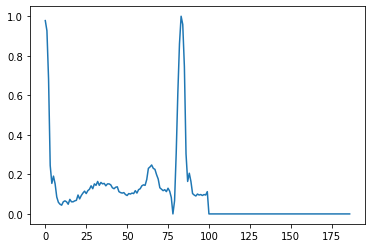

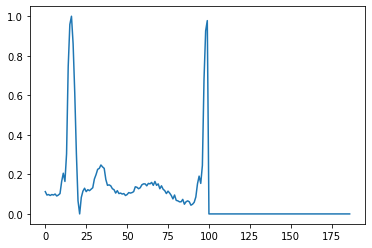

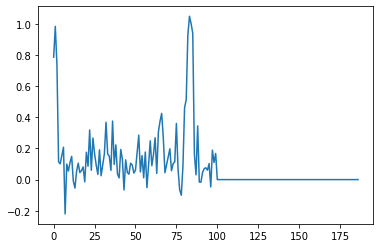

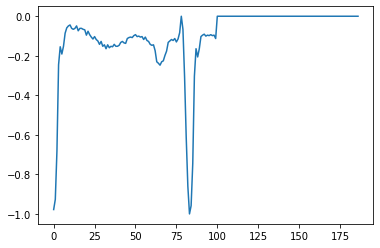

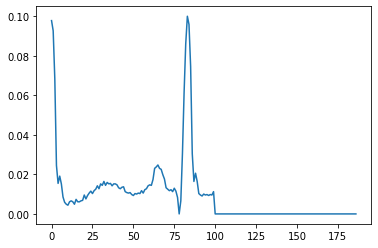

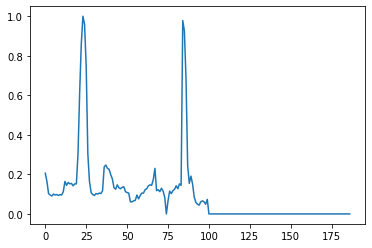

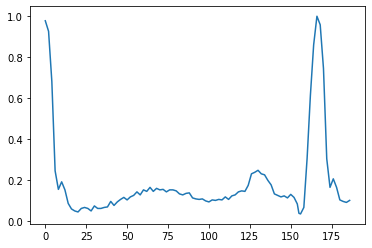

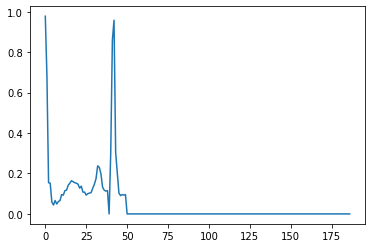

In [18]:
"""
plot_scan(train_df, 0)
plot_scan(train_df_flipped, 0)
plot_scan(train_df_noise, 0)
plot_scan(train_df_negated, 0)
plot_scan(train_df_scaled, 0)
plot_scan(train_df_shuffled, 0)

plot_scan(train_df_stretched, 0)
plot_scan(train_df_squeezed, 0)
plt.show()
"""